In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
import cv2

__We are taking the image of only those classes which have atleast 70 image and resizing the image__ 

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70,resize=0.4)
n_samples, h, w = lfw_people.images.shape

__X          : is the Matrix of Images with images being in column__
<br>
__n_features : is no of images in Dataset__
<br>
__y          : contains the label of each Image__
<br>
__n_classes  : represents No of distinct images__ 

In [3]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


__Spliting the Dataset in test and train with percentage of test dataset being 25%__

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


__Calculating the Average Face from the Training Images and Centering the Train and Test Image Matrix__

In [5]:
avgFace =  np.mean(X_train,axis=0)
X_train_centred = X_train - avgFace
X_test_centred = X_test - avgFace
print(X_train.shape)# we have 966 sample In train
print(X_test.shape)# we have 322 smaple in Test

(966, 1850)
(322, 1850)


__This is code is using the standard PCA from sklearn For Comparision purpose with our implementation of PCA__

In [6]:
from sklearn.decomposition import PCA
n_components = 150
pca = PCA(n_components=n_components,whiten='True',svd_solver="randomized").fit(X_train_centred)
pcaEigenvector = pca.components_
X_train_pca = pca.transform(X_train_centred)
X_test_pca = pca.transform(X_test_centred)

####################################
# Prediction 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train_pca,y_train)
correct=0
incorrect=0
predictedLabel = neigh.predict(X_test_pca)
for i in range(len(y_test)):
    if(y_test[i] ==predictedLabel[i]):
        correct=correct+1
    else:
        incorrect=incorrect+1
print("Accuracy : ",correct/(incorrect+correct))

Accuracy :  0.7049689440993789


__With the Standard Implementation we are able to get an Accuracy of 70.47%__

<br>
<br>
<br>
<br>


__PCA Implementation From scratch__ 

 1. __Calculating Covariance Matrix of $X.X^{T}$__

In [7]:
coVariance_Matrix =np.matmul(X_train_centred,X_train_centred.T)

In [8]:
print(coVariance_Matrix.shape)

(966, 966)


2. __Calculating the Eigen Value and Eigen Vector of $X.X^{T}$__

In [9]:
#Calculating Eigen Vector and Value
w , v = np.linalg.eig(coVariance_Matrix)# W is eigenVector and V is Matrix of EigenVector ColoumnWise

we got 966 Eigen Value and Eigen Vector

In [10]:
print(v[0,:].shape)

(966,)


__This is the Plot showing the first 20 eigen values__

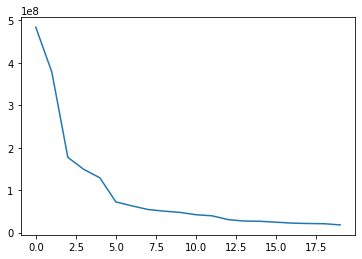

In [11]:
plt.plot(w[:20])
plt.show()

3. __Sorting the Eigen Vectors based on their Eigen Values in decreasing Order__ 

In [12]:
eigenVal_eigenVec = list()
for i in range(X_train.shape[0]):
    eigenVal_eigenVec.append([w[i] , v[:,i]])
sortedeeV =sorted(eigenVal_eigenVec, key=lambda x: x[0],reverse=True)


4. __Converting the Eigen Vectors from Face space to Original space__ 

In [22]:
#Converting eigenvector from 966 x1  to  2914x 1
#Square root 
eigenVectors = list()
for i in sortedeeV:
    eigenVector = np.matmul(X_train.T,i[1])/i[0]
    #unitEigenVector = eigenVector/(np.linalg.norm(eigenVector))
    eigenVectors.append(eigenVector)
eigenVectors = np.asarray(eigenVectors)
print(eigenVectors.shape)

(966, 1850)


__The Below is the compraision of eigen Vectors generated from PCA from sklearn and eigen Vectors from Our Implementation__

(150, 1850)
(150, 1850)


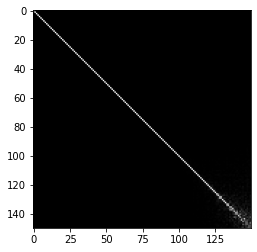

[1.0000004  0.99999976 1.0000001  0.9999999  1.         0.99999946
 0.99999994 0.9999999  1.0000001  1.         1.0000002  1.0000001
 1.         1.0000001  1.0000002  0.99999976 1.0000007  1.
 1.0000004  1.0000001  1.0000001  1.         1.0000006  0.9999998
 0.9999999  1.         0.99999934 1.0000004  1.0000004  1.
 1.0000001  1.         0.9999999  1.0000001  0.99999994 0.99999964
 1.         0.9999999  1.         1.0000002  1.         0.9999999
 1.0000006  0.99999994 0.99999946 1.0000002  1.         0.99999976
 0.9999999  0.9999999  1.0000001  1.0000001  1.0000002  1.
 0.9999996  1.0000002  0.99999964 1.0000001  0.9999996  0.9999991
 0.99999994 0.99999875 0.9999986  0.9999988  0.9999976  0.99999917
 0.99999875 0.9999978  0.99999845 0.99999857 0.9999972  0.99999666
 0.99999577 0.99999523 0.99999416 0.99998987 0.99999225 0.99999297
 0.9999787  0.9999875  0.9999621  0.99998325 0.9999851  0.999966
 0.9999918  0.9999596  0.99997    0.9999531  0.99991155 0.9999635
 0.99988663 0.99989605 0.9

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

topEigenVectors = eigenVectors[:n_components,:]
print(topEigenVectors.shape)
print(pcaEigenvector.shape)

matrixW = np.abs(cosine_similarity(pcaEigenvector,topEigenVectors))
plt.imshow(matrixW,cmap='gray')
plt.show()
cosineSimilarity = np.diag(matrixW)
print(cosineSimilarity)
# Not much Irregularity just direction Changes and at few Places the Similarity  

From the above it is clear that the almost 130 eigen vectors are similar to that of standard pca from sklearn. As the cosine similarity of a vector for it self should be 1 which is happening  and  evident from the white line in the digonal and other are black which means zero which also shows that eigen Vectors are Orthogonal.

__First 15 Eigen Faces__

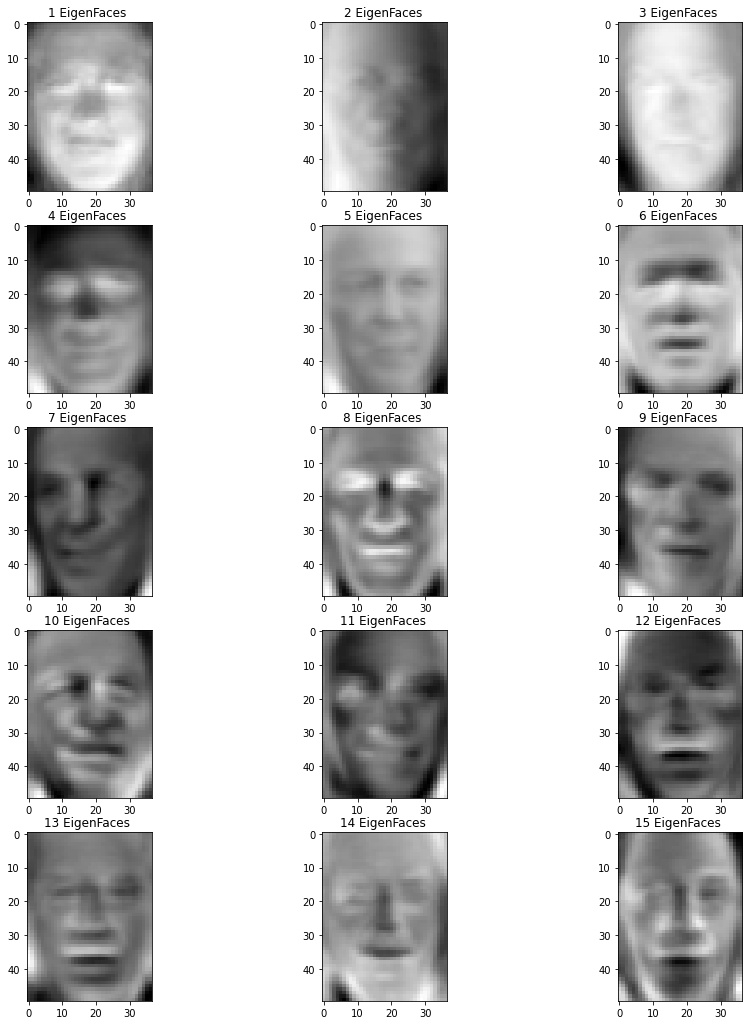

In [24]:
# Img Dimensons 62 x 47
fig ,axs = plt.subplots(5,3,figsize=(15,18))
for i in range(5):
    for j in range(3):
        axs[i,j].set_title(str(3*i+j+1) + " EigenFaces ")
        axs[i,j].imshow(eigenVectors[3*i+j].reshape(50,37),cmap = 'gray')

__The eigenRepresentation function takes a image and project it to the face space by taking the dot product of the image with the top N eigen Vectors__

In [25]:
def eigenRepresentation(img,eigenVectors,dim):
    imgReresentation = np.zeros((dim))
    for i in range(dim):
        imgReresentation[i] = np.dot(img,eigenVectors[i])/np.linalg.norm(img)
    return imgReresentation
n_dim_pca = 150
X_train_pca = list()# Projecting the training set
for sample in X_train_centred:
    X_train_pca.append(eigenRepresentation(sample,eigenVectors,n_dim_pca))
X_test_pca = list()# Projecting the testing set
for sample in X_test_centred:
    X_test_pca.append(eigenRepresentation(sample,eigenVectors,n_dim_pca))
avgProjectedFace = np.mean(X_train_pca,axis=0)

__faceOrNot function determine wether a image is of face or not by Calculating its distance from average projected Face__

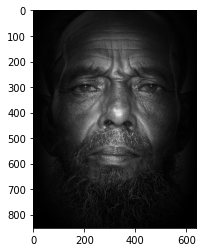

Distance From Average Face :  8.815391731912273e-05
The Image is Face


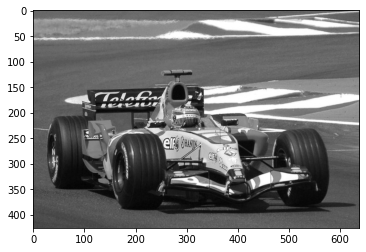

Distance From Average Face :  0.00026173961442678553
The Image is Face


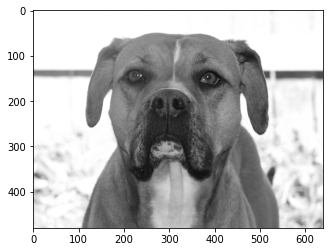

Distance From Average Face :  0.00022315832505008816
The Image is Face


In [26]:
# Non of the below image were in the tarning data
face = cv2.imread('face.jpg')
car  = cv2.imread('car.jpg')
dog  = cv2.imread('dog.jpg')
face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
car = cv2.cvtColor(car,cv2.COLOR_BGR2GRAY)
dog = cv2.cvtColor(dog,cv2.COLOR_BGR2GRAY)

def faceOrNot(img,eigenVectors,n_dim_pca,avgProjectedFace,avgFace):# A Gray Scale Image as input
    resizedImg = cv2.resize(img,(50,37))# Resize to match the dim of data in our Image space
    centeredImg = resizedImg.flatten() - avgFace# Centering the Data
    projectedImg = eigenRepresentation(centeredImg,eigenVectors,n_dim_pca)#Projecting the image to Face space
    dist = np.linalg.norm(projectedImg - avgProjectedFace)#Calculating the Euclidean Distance 
    print("Distance From Average Face : ",dist)
    if(dist < 0.001):# The threshold we got after experimentation
        print("The Image is Face")
    else:
        print("The Image is not a Face ")
plt.imshow(face,cmap='gray')
plt.show()
faceOrNot(face,eigenVectors,n_dim_pca,avgProjectedFace,avgFace)
plt.imshow(car,cmap='gray')
plt.show()
faceOrNot(car,eigenVectors,n_dim_pca,avgProjectedFace,avgFace)
plt.imshow(dog,cmap='gray')
plt.show()
faceOrNot(dog,eigenVectors,n_dim_pca,avgProjectedFace,avgFace)

In [18]:
#Label to Image Map
labeltoImg = dict()
for i in range(X_train.shape[0]):
    labeltoImg[y_train[i]] = X_train[i,:]

__Below are the seven classes that we have__

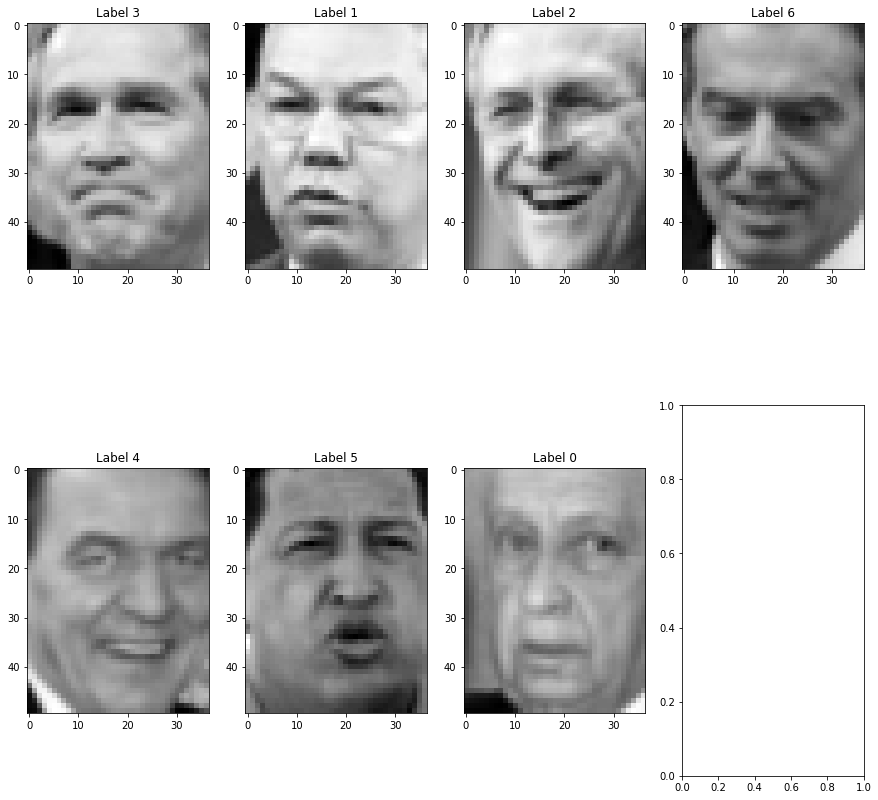

In [19]:
fig ,axs = plt.subplots(2,4,figsize=(15,15))
i=0
for key ,img in labeltoImg.items():
    axs[i//4,i%4].set_title('Label '+ str(key) )
    axs[i//4,i%4].imshow(img.reshape(50,37),cmap='gray')
    i=i+1
plt.show()

In [20]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train_pca,y_train)
correct=0
incorrect=0
correctList = dict()
incorrectList = dict()
incorrectLabel = dict()
predictedLabel = neigh.predict(X_test_pca)
for i in range(len(y_test)):
    if(y_test[i] ==predictedLabel[i]):
        correctList[y_test[i]] =[X_test[i,:].reshape(50,37),labeltoImg[predictedLabel[i]].reshape(50,37)]
        correct=correct+1
    else:
        incorrectList[y_test[i]] = [X_test[i,:].reshape(50,37),labeltoImg[predictedLabel[i]].reshape(50,37)]
        incorrectLabel[y_test[i]] = predictedLabel[i]
        incorrect=incorrect+1
print("Correct : ",correct)
print("Incorrect : ",incorrect)
print("Accurecy : ",correct/(incorrect+correct))
#Print Only acc

Correct :  199
Incorrect :  123
Accurecy :  0.6180124223602484


__We are using Knn for classfication in the face space with 4 nearest neighbors working best for our dataset we got an accurecy of 61.5% in our implementation and in standard pca from sklearn we got accuracy of 68.01%__

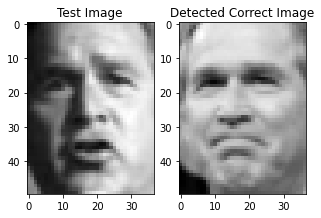

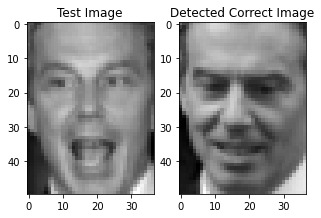

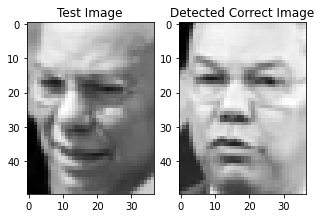

In [21]:
for test,detected in list(correctList.values())[:3]:
    fig , axs = plt.subplots(1,2 , figsize=(5,10))
    axs[0].imshow(test,cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(detected,cmap='gray')
    axs[1].set_title('Detected Correct Image')
    plt.show()

__Above are some example of Classification__